In [1]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# This cell allows for all the output to be displayed without scrolling (up to the max-height var in pixels)

In [2]:
import importlib

# List of required libraries
libraries = [
    'ipywidgets',
    'IPython',
    'scipy',
    'numpy',
    'matplotlib',
    'tqdm',
    'pandas',
    'pybaselines',
    'spe2py'
]


# Check if each library is installed, and install if necessary
for library in libraries:
    try:
        importlib.import_module(library)
        print(f"{library} is already installed")
    except ImportError:
        print(f"{library} is not installed. Installing...")
        !pip install {library}
        print(f"{library} installed successfully")

# Import the required packages
from helpers import *
from ipywidgets import *
from IPython.display import display, Javascript
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.signal import find_peaks
from scipy.signal import medfilt
from scipy import signal
import peakutils
from peakutils.plot import plot as pplot
from matplotlib.animation import FuncAnimation
from scipy import stats
from numpy.fft import fft, fftfreq, ifft
import glob
from tqdm import tqdm
import pandas as pd
import oceanopticsdatareader as oodr
import dataprocessing as dp
from system_response import SystemResponse


ipywidgets is already installed
IPython is already installed
scipy is already installed
numpy is already installed
matplotlib is already installed
tqdm is already installed
pandas is already installed
pybaselines is already installed
spe2py is already installed


In [3]:
## Scientific Constants

h = 6.626e-34 #Planck's constant in Js
heV = 4.136e-15 #Planck's constant in eVs
c = 2.9979e8 #Speed of light in m/s
kb = 1.381e-23 #Boltzmann constant in J/K
kbeV = 8.617e-5 #Boltzmann constant in eV/K
scale = 2e-9
#pixelArea = (20e-6)*(20e-6)*100; # LN Spectrometer Area of 100, 20um x 20um pixels per wavelength
pixelArea = (14e-6)*(200e-6); # Ocean Optics UV Vis 14um x 200um per wavelength
# acquisitionTime = 0.5; # Acquisition time is seconds

In [4]:
do_intensity_corr_data_cleaning = 'n'

if do_intensity_corr_data_cleaning == 'y':
    
    do_median_filtering = 'n'
    do_data_cleaning = 'n'
    erp = 10 
    k_size = 3
    
    print("\nSelect tungsten halogen (Blue Ocean optics HL2000) lamp spectrum for intensity correction \n(optional; if none is chosen, default intensity correction factor will be used): ")
    selectHalLamp_1 = SelectFilesButton()
    display(selectHalLamp_1)
else:
    pass

In [5]:
# Create an instance of the DataProcessing class
data_processor = oodr.OceanOpticsDataReader()

# Define your processing options
do_median_filtering = 'n'
do_savgol_filtering = 'n'
do_data_cleaning = 'n'
erp = 10
k_size = 3
k_size_savgol = 51
p_order_savgol = 1

if do_intensity_corr_data_cleaning == 'y':

    flamp_1 = selectHalLamp_1.files

    for i in tqdm(range(len(flamp_1))):

        head, tail = os.path.split(flamp_1[i])

        x_data, y_data = data_processor.get_multiple_ocean_optics_data(flamp_1, i)

        if do_savgol_filtering == 'y':
            savgol_filt_data = data_processor.filter_savgol(y_data, k_size_savgol, p_order_savgol)
        else:
            savgol_filt_data = y_data

        if do_median_filtering == 'y':
            filt_data = data_processor.filter_median(savgol_filt_data, k_size)
        else:
            filt_data = savgol_filt_data

        if do_data_cleaning == 'y':
            cleaned_data = data_processor.data_cleaning(filt_data, erp)
        else:
            cleaned_data = filt_data

        max_val_intensity = 3000  # Set the value of intensity that an intensity correction file should have to get considered

        if np.max(cleaned_data) > max_val_intensity:
            # print(flamp_1[i])

            datamatrix = np.column_stack((x_data, cleaned_data))  # Compiles corrected data into a new matrix
            savename = flamp_1[i][:-4] + "_cleaned.txt"  # Create filename for new data
            # np.savetxt(savename, datamatrix)  # Save new data

    # plt.plot(x_data, y_data, label='Intensity Correction Lamp Data')
    # plt.plot(x_data, cleaned_data, label='Cleaned Data')
    # plt.plot(x_data,filt_data)
    # plt.plot(x_data,savgol_filt_data)

    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (a.u.)')
    # plt.ylim(0,1000)
    plt.legend()
    # plt.ylim(100,250)
    plt.title(tail)
    plt.show()
else:
    pass

In [6]:
print("Select data files:")
selectFiles = SelectFilesButton()
display(selectFiles)

do_intensity_correction = 'y'

if do_intensity_correction == 'y':
    print("Select data dark BKG: (Optional, don't use if background already subtracted)")
    selectDark = SelectFilesButton()
    display(selectDark)
    print("________________________________________________________________________________________________________")

    print("\nSelect tungsten halogen (Blue Ocean optics HL2000) lamp spectrum for intensity correction \n(optional; if none is chosen, default intensity correction factor will be used): ")
    selectHalLamp = SelectFilesButton()
    display(selectHalLamp)

    print("\nSelect baseline spectrum for tungsten lamp measurement: (Optional, don't use if background already subtracted)")
    selectBaseline = SelectFilesButton()
    display(selectBaseline)
    print("________________________________________________________________________________________________________")

else:
    pass

Select data files:


SelectFilesButton(description='Select File', icon='square-o', style=ButtonStyle(button_color='orange'))

Select data dark BKG: (Optional, don't use if background already subtracted)


SelectFilesButton(description='Select File', icon='square-o', style=ButtonStyle(button_color='orange'))

________________________________________________________________________________________________________

Select tungsten halogen (Blue Ocean optics HL2000) lamp spectrum for intensity correction 
(optional; if none is chosen, default intensity correction factor will be used): 


SelectFilesButton(description='Select File', icon='square-o', style=ButtonStyle(button_color='orange'))


Select baseline spectrum for tungsten lamp measurement: (Optional, don't use if background already subtracted)


SelectFilesButton(description='Select File', icon='square-o', style=ButtonStyle(button_color='orange'))

________________________________________________________________________________________________________


In [7]:
## Variables for Planck's fitting

acquisitionTime = 0.0007 # 500ms acquistion time
#T0 = 1000 # Initial temperature guess in degrees K

do_system_correction = 'y'
do_intensity_correction = 'n'
do_baseline_subtraction = 'n'
do_median_filtering = 'n'
do_data_cleaning = 'n'
do_planck_fit = 'n' # Do Planck's fit
p_order = 5 # Polynomial order for baseline subtraction
k_size = 3 # Kernel size for Median Filtering
erp = -11

wvl_start = 400 # Wavelength start range to fit in nm
wvl_end = 580 # Wavelength end range to fit in nm
T0 = 400 # Initial temperature guess in degrees K
scale_factor = 1e-6 # Scale factor for fitting

  0%|          | 0/1 [00:00<?, ?it/s]

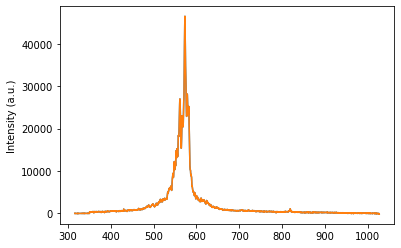

100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

Empty DataFrame
Columns: [file_name, Temperature(K)]
Index: []


In [8]:
# importlib.reload('plancks_law')

# Create instances of the classes
data_reader = oodr.OceanOpticsDataReader()
data_processor = dp.DataProcessing()

df_1 = pd.DataFrame(columns=['file_name', 'Temperature(K)'])
counter = 0

files = selectFiles.files
flamp = selectHalLamp.files
# files = glob.glob(r"H:\My Data\LH_data\05102023\G4_CA-Exp_16-LH_R3-loc_1_Subt16__28**__39494.txt")
# flamp = glob.glob(r"H:\My Data\LH_data\Intensity Correction\Intensity_correction-300ms_Subt12__20__021_cleaned.txt")

for file in tqdm(files):
    with open(file, 'r') as f:
        for line in f:
            if line.startswith('Integration Time (sec):'):
                integration_time = line.split(':')[1].strip()
                acquisitionTime = float(integration_time)
                # print(f'Integration time: {acquisitionTime} s')

    head, tail = os.path.split(file)

    # print(head)
    # print(tail)
    # print(file)

    counter = counter + 1

    x_data, y_data = data_reader.get_ocean_optics_data(file)
    # print(x_data,y_data)
    
    if do_system_correction == 'y':
        sr = SystemResponse(flamp)
        x_data, y_data, intens_data = sr.correct_system_response(file, save_correction=False)

    if do_intensity_correction == 'y':
        x_data, y_data, intens_data = data_processor.i_corr(file, flamp)
    else:
        intens_data = y_data

    # norm_intens_data = intens_data/np.max(intens_data)
    norm_intens_data = intens_data

    if do_median_filtering == 'y':
        filt_data = data_processor.filter_median(norm_intens_data, k_size)
    else:
        filt_data = norm_intens_data

    if do_baseline_subtraction == 'y':
        base = data_processor.subtract_bsl(filt_data, p_order)
    else:
        base = 0

    bsl_subt_data = filt_data - base

    if do_data_cleaning == 'y':
        cleaned_data = data_processor.data_cleaning(bsl_subt_data, erp)
    else:
        cleaned_data = bsl_subt_data

    # Plancks fitting process
    
    if do_planck_fit == 'y':

        pixelResolution = (x_data[-1] - x_data[-2])  # delta wavelength nm
        # print('Pixel Resolution = ' + str(pixelResolution))

        y_spec_irr = np.zeros(shape=len(x_data))
        photonFlux = np.zeros(shape=len(cleaned_data))
        for j in range(len(x_data)):
            photonFlux[j] = cleaned_data[j] / (pixelArea * acquisitionTime)
            y_spec_irr[j] = photonFlux[j] * (h * c / (x_data[j] * 10 ** -9)) / (pixelResolution)  # spectral irradiance in W/m^2-nm

        # y_spec_irr_norm = y_spec_irr/np.max(y_spec_irr)
        # y_spec_irr_norm = (y_spec_irr - np.min(y_spec_irr))/(np.max(y_spec_irr)-np.min(y_spec_irr))
        y_spec_irr_norm = y_spec_irr

        # print(x)
        start = np.argmin(abs(x_data[1:] - wvl_start))
        end = np.argmin(abs(x_data[1:] - wvl_end))
        # print(start, end)
        wa = x_data[start:end]
        ydata_1 = y_spec_irr_norm[start:end]
        cleaned_data_crop = cleaned_data[start:end]
        
        from plancks_law import PlancksLaw

        # Create an instance of the PlancksLaw class
        plancks_law = PlancksLaw()
        T0 = 3000 # Initial temperature guess in degrees K
        scale_factor = 1e-13 # Scale factor for fitting
        # Fit the data to the blackbody radiation function
        fit_params, _ = curve_fit(plancks_law.calculate_spectral_irradiance, wa, cleaned_data_crop, p0=[scale_factor, T0])

        # Extract the fitted parameters
        fitted_scale_factor, fitted_temperature = fit_params

        # get the best fitting parameter values and their 1 sigma errors
        # (assuming the parameters aren't strongly correlated).

        ybest = plancks_law.calculate_spectral_irradiance(wa, fitted_scale_factor ,fitted_temperature)
        yblack = plancks_law.calculate_spectral_irradiance(wa, fitted_scale_factor ,T0)
        
        # Calculate system response by dividing the data by the blackbody radiation function at T = 2413.13 K
        system_response = cleaned_data_crop/plancks_law.calculate_spectral_irradiance(wa, fitted_scale_factor ,2413.13)

        # plot the solution
        # plt.plot(wa,cleaned_data_crop,label='Lamp Data')
        # plt.plot(wa,yblack,label=f'Input Temperature {T0} K')
        # plt.plot(wa, ybest, ls= '--',label=f'Best fitting model {fitted_temperature:.2f} K')
        plt.plot(wa,system_response,label='System Response')
        # plt.ylim(0,1)
        plt.legend()
        plt.xlabel("Wavelength (nm)")
        plt.show()
        
    else:
        y_spec_irr_norm = cleaned_data
        plt.plot(x_data, y_spec_irr_norm, label='Intensity corrected data')
        plt.plot(x_data, y_data, label='Raw data')
        plt.ylabel("Intensity (a.u.)")

    # plt.title(tail) # File name as the plot title
    # plt.xlabel("Wavelength (nm)")
    # plt.legend(frameon=True)
    #plt.savefig('')
    plt.show()
print(df_1)
# df_1.to_csv(r'temp_val_2.csv',index=False,header=True)

In [27]:
len(files)

NameError: name 'files' is not defined

In [28]:
# df_1 = pd.read_csv('temp_val_2.csv')

x = df_1['file_name'].to_numpy()
y = df_1['Temperature(K)'].to_numpy()

#fig1 = plt.figure()
#plt.axis([0, 10, 0, 1])

#for i in range(316):
    #y = np.random.random()
for idx, yi in enumerate(y):
#     if yi>1200:
    plt.scatter(idx,yi)
plt.xlabel('time (a.u.)')
plt.ylabel('Temperature (K)')
plt.title('Best Fit Temperature for one spot - Planck emission')
    #plt.pause(0.05)

plt.show()

NameError: name 'df_1' is not defined

In [29]:
def plot_plancks_function(temperature, wavelength_range=(100, 1000)):
    """
    Plot Planck's function for a given temperature.

    Parameters:
    - temperature: Blackbody temperature (in Kelvin)
    - wavelength_range: Tuple specifying the wavelength range (in nm) to plot (default: 100 to 1000 nm)
    """
    wavelength = np.linspace(wavelength_range[0], wavelength_range[1], 500)
    data_processor = DataProcessing()
    spectral_radiance = data_processor.blackbody_lam(wavelength, temperature)

    # plt.figure()
    plt.plot(wavelength, spectral_radiance, label=f'Temperature {temperature} K')
    plt.xlim(400,wavelength_range[1])
    plt.ylim(0,0.0001)
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Spectral Radiance (W/(sr-m^2-nm))")
    plt.legend()
    plt.title(f'Planck\'s Function at {temperature} K')

def plot_multiple_temperatures(temperatures, wavelength_range=(100, 1000)):
    """
    Plot Planck's functions for multiple temperatures.

    Parameters:
    - temperatures: List of blackbody temperatures (in Kelvin)
    - wavelength_range: Tuple specifying the wavelength range (in nm) to plot (default: 100 to 1000 nm)
    """
    for temp in temperatures:
        plot_plancks_function(temp, wavelength_range)

    plt.show()

# Usage example
if __name__ == "__main__":
    temperatures = [1200, 1000, 800, 600, 400, 200]
    for temp in temperatures:
        plot_plancks_function(temp, wavelength_range=(300, 1050))
    # plot_multiple_temperatures(temperatures)
    plt.show()


NameError: name 'DataProcessing' is not defined

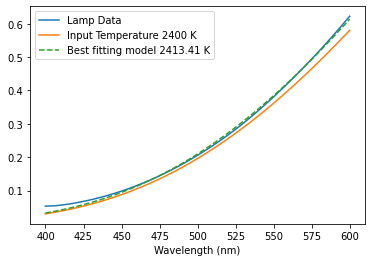

In [30]:
import numpy as np
from plancks_law import PlancksLaw
from oceanopticsdatareader import OceanOpticsDataReader
import matplotlib.pyplot as plt
# Create an instance of the OceanOpticsDataReader class
data_reader = OceanOpticsDataReader()
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit

# Lamp data
# lamp_wavelength, lamp_intensity = data_reader.get_ocean_optics_data(flamp)  # Replace with your lamp data retrieval code
## Important note to change the location of this .txt file below to where it is in your computer.
calibstd = np.loadtxt(r"G:\Shared drives\Pauzauskie Team Drive\Users\CG\Scripts\030410638_HL-2000-CAL_2014-01-15-14-09_VISEXT1EXT2_FIB.txt")
lamp_wavelength = calibstd[:,0]
lamp_intensity = calibstd[:,1]
x = np.linspace(300, 1000, 3000)
HglampFunc = CubicSpline(lamp_wavelength, lamp_intensity)
hglampI = HglampFunc(x) # Create interpolation of true lamp spectrum
lamp_wavelength = x
lamp_intensity = hglampI


# Set a range of wavelengths to fit over
start_wavelength = 400
end_wavelength = 600
wavelength_range = (start_wavelength, end_wavelength)

# Crop the lamp data to the specified wavelength range
start_index = np.argmin(abs(lamp_wavelength - start_wavelength))
end_index = np.argmin(abs(lamp_wavelength - end_wavelength))
lamp_wavelength = lamp_wavelength[start_index:end_index]
lamp_intensity = lamp_intensity[start_index:end_index]

# Create an instance of the PlancksLaw class
plancks_law = PlancksLaw()
T0 = 2400 # Initial temperature guess in degrees K
scale_factor = 1e-13 # Scale factor for fitting
# Fit the data to the blackbody radiation function
fit_params, _ = curve_fit(plancks_law.calculate_spectral_irradiance, lamp_wavelength, lamp_intensity, p0=[scale_factor, T0])

# Extract the fitted parameters
fitted_scale_factor, fitted_temperature = fit_params

# get the best fitting parameter values and their 1 sigma errors
# (assuming the parameters aren't strongly correlated).

ybest = plancks_law.calculate_spectral_irradiance(lamp_wavelength, fitted_scale_factor ,fitted_temperature)
yblack = plancks_law.calculate_spectral_irradiance(lamp_wavelength, fitted_scale_factor ,T0)

# plot the solution
plt.plot(lamp_wavelength,lamp_intensity,label='Lamp Data')
plt.plot(lamp_wavelength,yblack,label=f'Input Temperature {T0} K')
plt.plot(lamp_wavelength, ybest, ls= '--',label=f'Best fitting model {fitted_temperature:.2f} K')
# plt.ylim(0,1)
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.show()
# plt.ylabel("Spectral Irradiance (W/m$^2$-nm)")


In [15]:
print(f'The fitted temperature is {fitted_temperature:.2f} K')
print(f'The fitted scale factor is {fitted_scale_factor:.2e}')

The fitted temperature is 2413.41 K
The fitted scale factor is 8.28e-12


In [6]:
# Plot the balckbody radiation function for initial guess

plt.plot(lamp_wavelength, plancks_law.calculate_spectral_irradiance(lamp_wavelength, scale_factor, T0), label=f'Initial guess {T0} K')
plt.show()


NameError: name 'plancks_law' is not defined